<a href="https://colab.research.google.com/github/Mintas/diving-deep-learning/blob/master/Test_learning_for_different_batch_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
#%cd diving-deep-learning/
!git clone https://github.com/Mintas/diving-deep-learning.git
#!git checkout origin/master
#!git fetch
#!git pull

sample_data
Cloning into 'diving-deep-learning'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 220 (delta 124), reused 168 (delta 76), pack-reused 0
Receiving objects: 100% (220/220), 4.05 MiB | 2.58 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [0]:
!cat /proc/meminfo

In [0]:
!cat /proc/cpuinfo

In [2]:
!ls
%cd diving-deep-learning/

diving-deep-learning  sample_data
/content/diving-deep-learning


In [0]:
from __future__ import print_function
# %matplotlib inline
import random
import torch
import torch.nn as nn
import torch.utils.data

import domain.ecaldata
import domain.parameters

import training.losses
import training.optimDecorators
from plots import painters, plotUi
import mygan
import architectures.dcgan02062019 as myzoo#dcganBatchNorm as myzoo
from training import trainer
import numpy as np
from serialization import iogan

from analytics import analytic_funcs as AF
from analytics import optimized_analytic_funcs as OAF
from os.path import dirname
import matplotlib.pyplot as plt
from timeit import default_timer as timer




In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [5]:
from google.colab import drive
drive.mount('/ecal')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /ecal


In [6]:
%cd /
%cd ecal/My Drive/ecal

# dataSet = myfuncs.ProbDistrDataset(torch.distributions.normal.Normal(0,1), 128000)
datasetName = 'caloGAN_v3_case2_50K'
ecalData = np.load('%s.npz' % datasetName)

/
/ecal/My Drive/ecal


In [7]:
%cd /
%cd content/diving-deep-learning/
%mkdir resources/computed

archVersion = 'dcganBatchNorm_incBs_x10' #arch version
resultingName = 'resources/computed/%s_%s' % (datasetName, archVersion)

/
/content/diving-deep-learning


In [8]:
# Set fixed random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [0]:

nc = 1  # we got 1channel response
nz = 100 # latent space size | 42 is close to hypotenuse of response 30x30
imgSize = 8  # our respons is 30x30
ngf = 30  # todo : decide Generator feature-space characteristic size
#ndf = 30  # decide Critic feature-space characteristic size
lr = 0.00015  # Learning rate for optimizers | 0.04 is good for SGD and 0.0001 for RMSProp
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers
ngpu = 1 if device else 0  # increase for GPU hosted calculations
gpWeight = 0.5 # gradient penalty weight; somehow 0.1 is nice, 1 is so so, 10 is bad, 0.01 is vanishing
type = mygan.GANS.WGAN # we are going to try gan, wgan-gp and cramerGan
initOptimizer = training.optimDecorators.optRMSProp  # works almost as well for SGD and lr = 0.03

hyperParams = domain.parameters.HyperParameters(ngpu, lr, beta1)
# Decide which device we want to run on
if device is None: device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



def initNet(netClass, hp, prblm, dvc):
    net = netClass(type, hp, prblm).to(dvc)
    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))
    net.apply(mygan.weights_init)
    #print(net)  # Print the model
    return net
  
problem = domain.parameters.ProblemSize(nz, ngf, nc, 1000, imgSize)
                                         
netG = initNet(GenEcal, hyperParams, problem, device)#initNet(myzoo.GenEcal, hyperParams, problem, device)
netD = initNet(DiscEcal, hyperParams, problem, device)#initNet(myzoo.DiscEcal, hyperParams, problem, device)
#print(netG)
#print(netD)
                 
ecalDataPojo = domain.ecaldata.dictToEcalData(ecalData)
if imgSize != 30:
  ecalDataPojo = domain.ecaldata.resizeResponses(ecalDataPojo, imgSize)
dataSet = torch.utils.data.TensorDataset(torch.from_numpy(ecalDataPojo.response).float())



In [24]:
print(ecalDataPojo.response.shape)
print(ecalData['EnergyDeposit'].shape)

(50000, 8, 8)
(50000, 30, 30)


HERE WE WILL DEFINE OUR TESTPLAN !!!


In [0]:
tds = len(dataSet)
#gonna train 50k dataset with batch_sizes of 50, 100, 250, 500, 1000, 2500, 5000, 10k, measured in % in testCases below
#NOTE !!! I decided to train nets for 200 epochs only, because of to slow learning process 
# [tds * 0.2, 200], [tds * 0.1, 200], , [tds * 0.002, 10], [tds * 0.005, 20], [tds * 0.02, 100],  [tds * 0.05, 100]
testPlan = [ [tds * 0.002, 10] ]# [tds * 0.001, 10],  [tds * 0.01, 25], [tds * 0.1, 50] ]
#testPlan = [ [tds * 0.2, 250]  ]


resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_incBs_x10 is found?     False
resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_incBs_x10_100	500.0
Starting Training Loop...
[0/10][0/500]	Loss_D: 0.4991	Loss_G: -0.0000	D(x): -0.0011	D(G(z)): 0.0000 / 0.0000
!!!!!! SAVING MODELS DONT BREAK EXECUTION !!!!!!
!!!!!! Models have been saved successfully !!!!!
[1/10][0/500]	Loss_D: -6.0647	Loss_G: 1.1242	D(x): 5.6999	D(G(z)): -1.1190 / -1.1242
[2/10][0/500]	Loss_D: -0.1887	Loss_G: 0.1202	D(x): 0.1042	D(G(z)): -0.1075 / -0.1202
[3/10][0/500]	Loss_D: -1.0154	Loss_G: 0.7172	D(x): 0.4766	D(G(z)): -0.7140 / -0.7172
[4/10][0/500]	Loss_D: -0.9019	Loss_G: 0.2380	D(x): 0.9069	D(G(z)): -0.1842 / -0.2380
[5/10][0/500]	Loss_D: -0.1385	Loss_G: -0.5269	D(x): 0.6470	D(G(z)): 0.4997 / 0.5269
[6/10][0/500]	Loss_D: -0.2684	Loss_G: -0.4625	D(x): 0.8106	D(G(z)): 0.5381 / 0.4625
[7/10][0/500]	Loss_D: -1.3551	Loss_G: -0.0605	D(x): 1.8852	D(G(z)): 0.1064 / 0.0605
[8/10][0/500]	Loss_D: -1.0195	Loss_G: 0

/content/diving-deep-learning/analytics/plotAnalytics.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img) if logScale else img, interpolation='nearest')
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.axes.set_ylim((ymin, ymax), auto=None)


<Figure size 432x288 with 0 Axes>

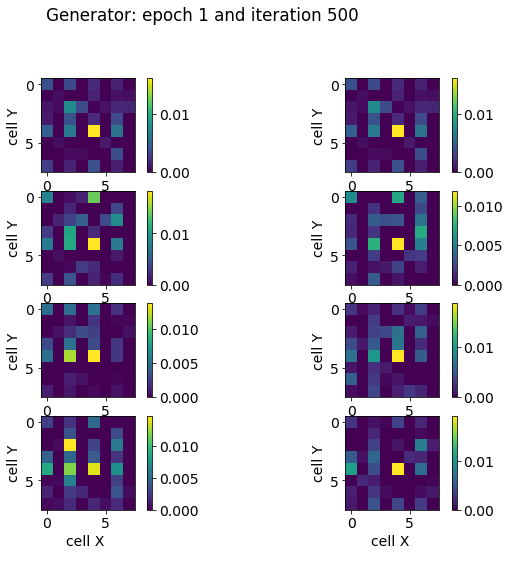

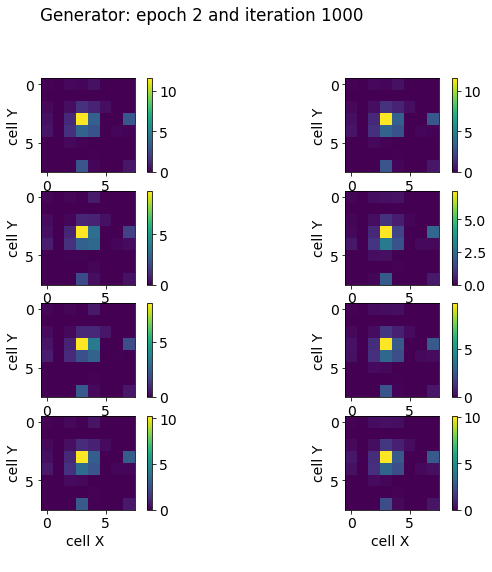

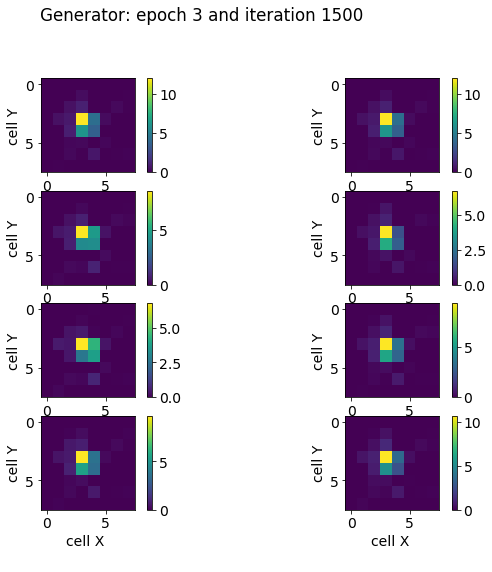

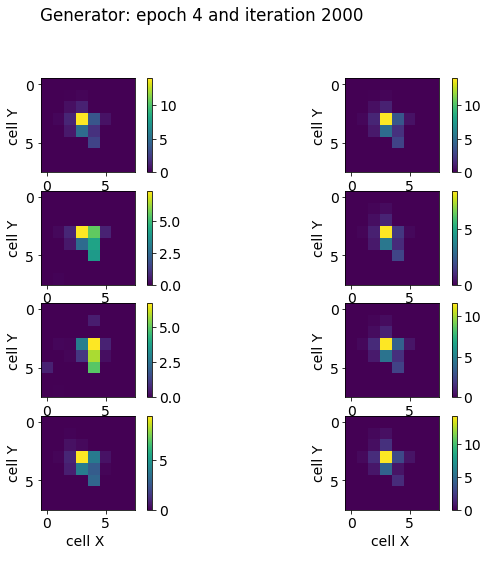

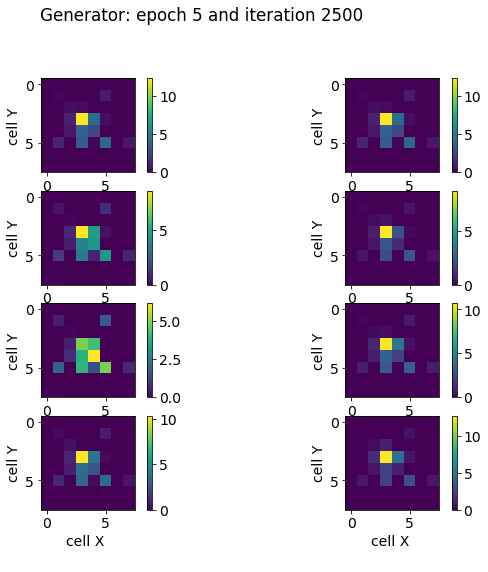

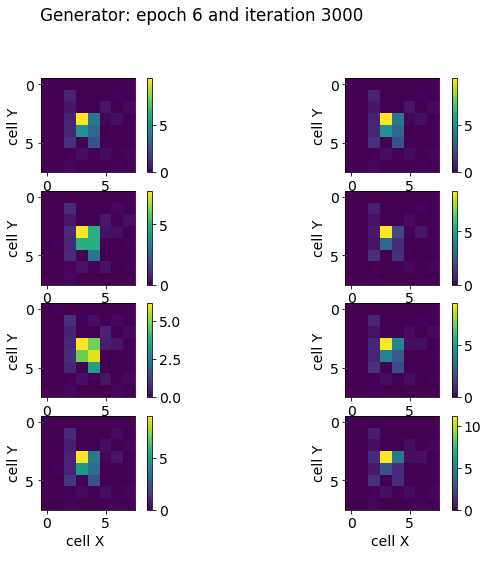

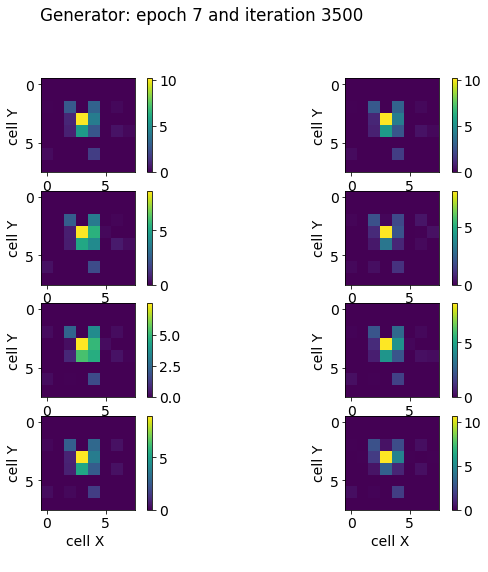

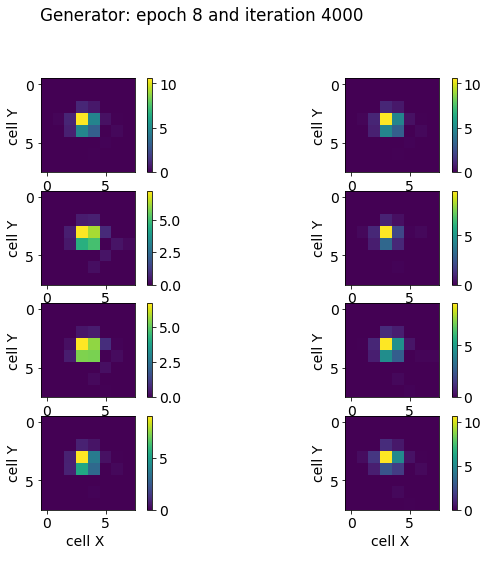

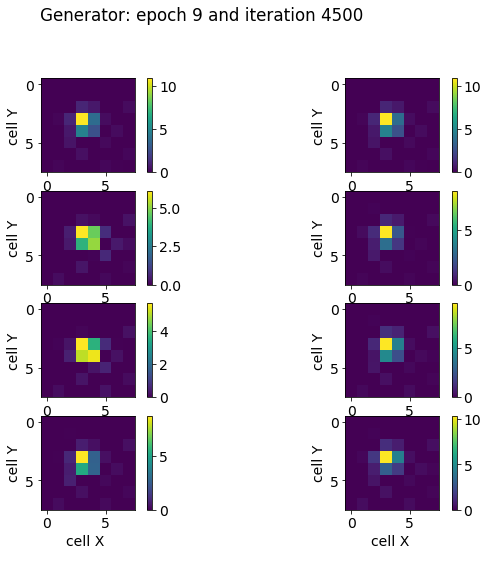

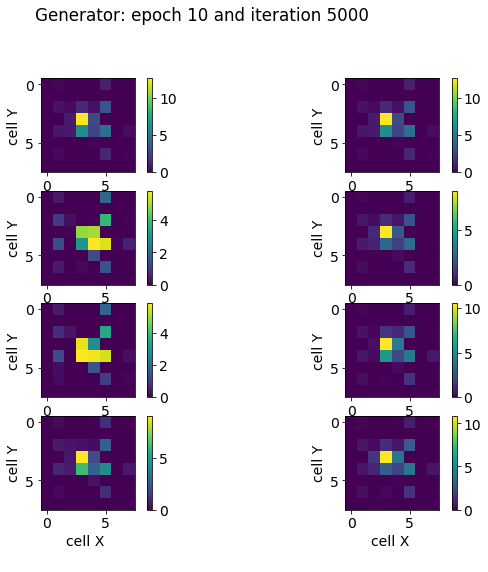

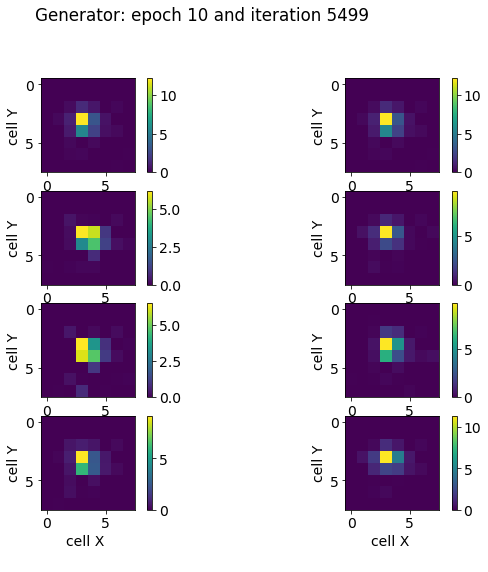

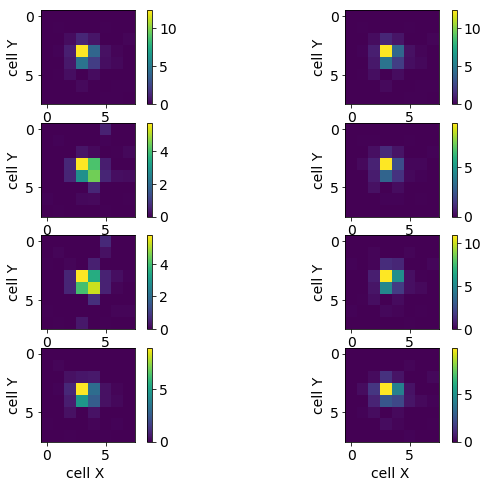

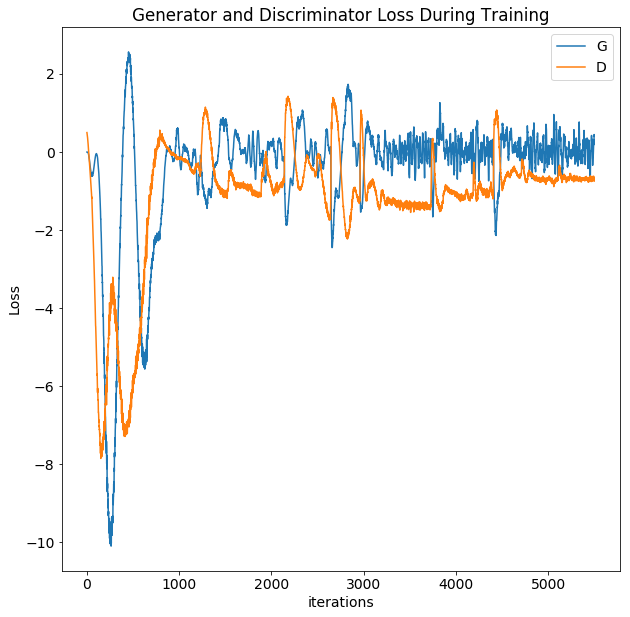

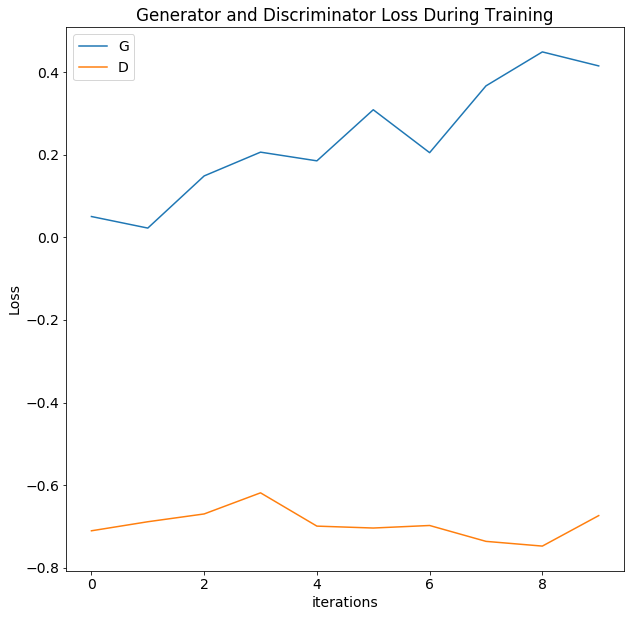

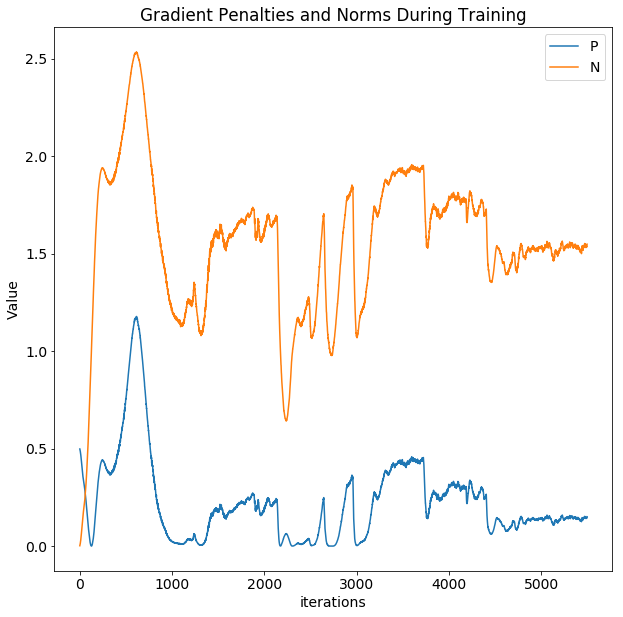

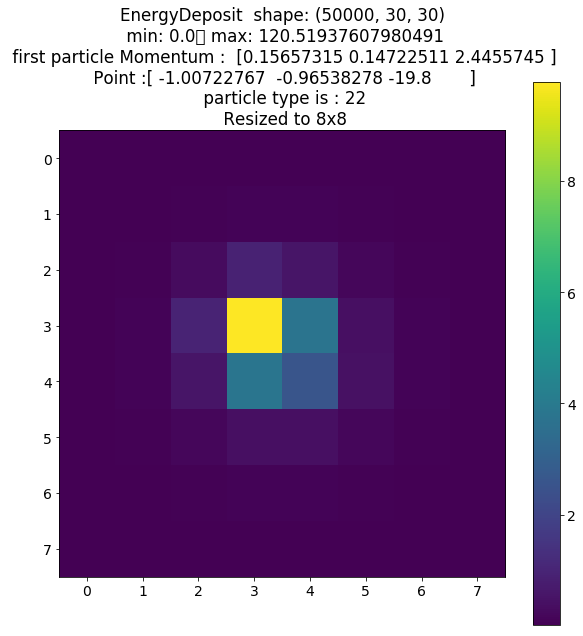

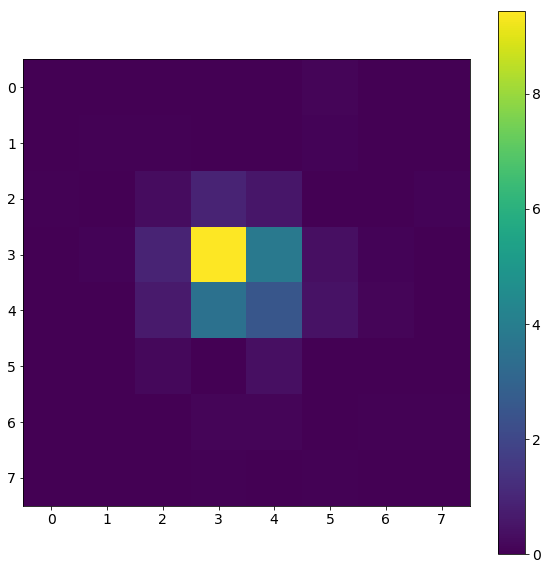

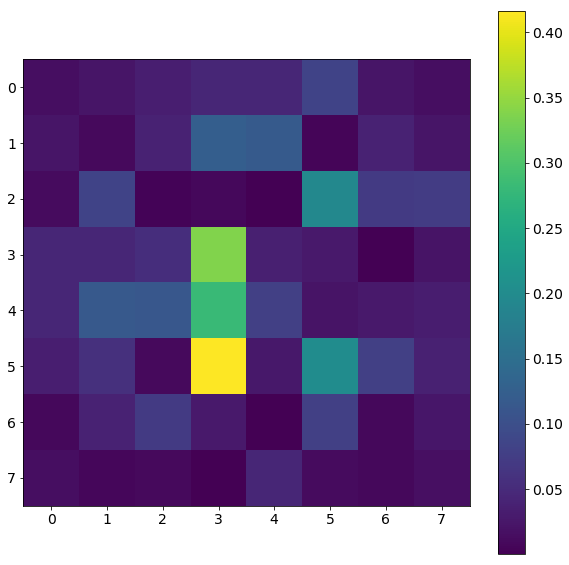

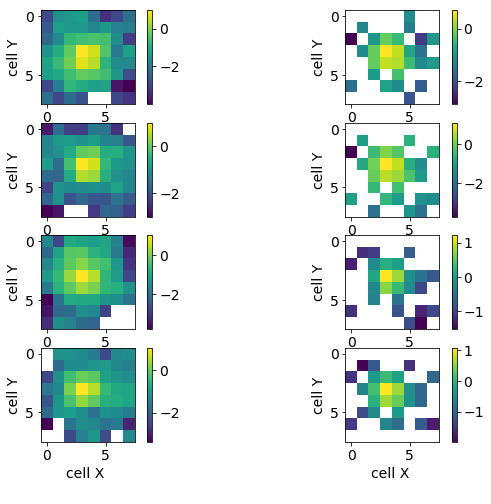

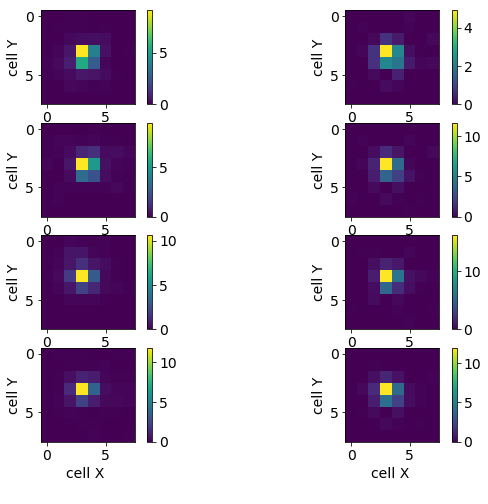

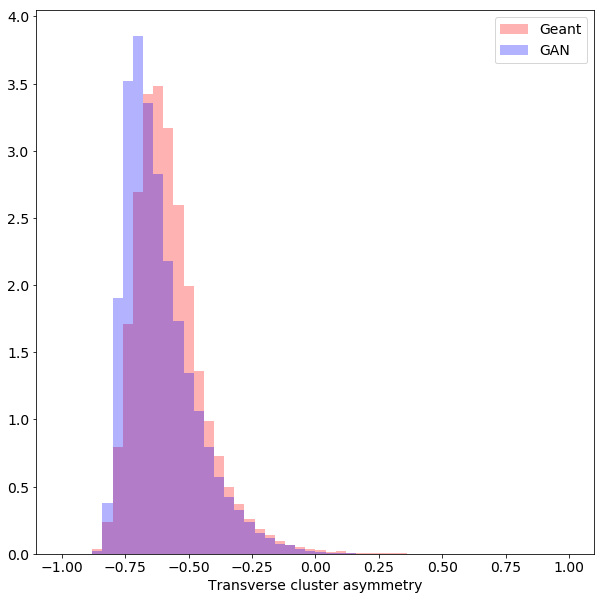

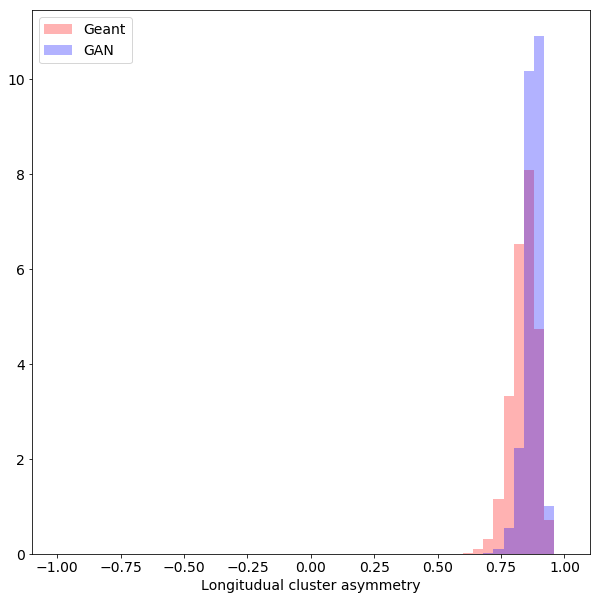

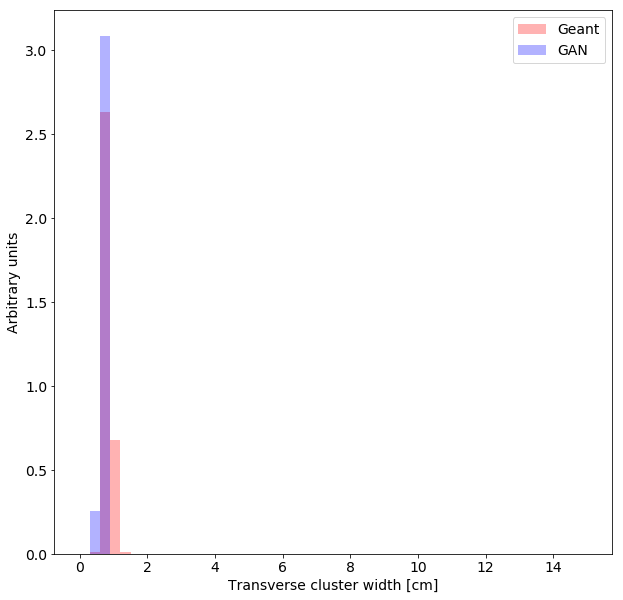

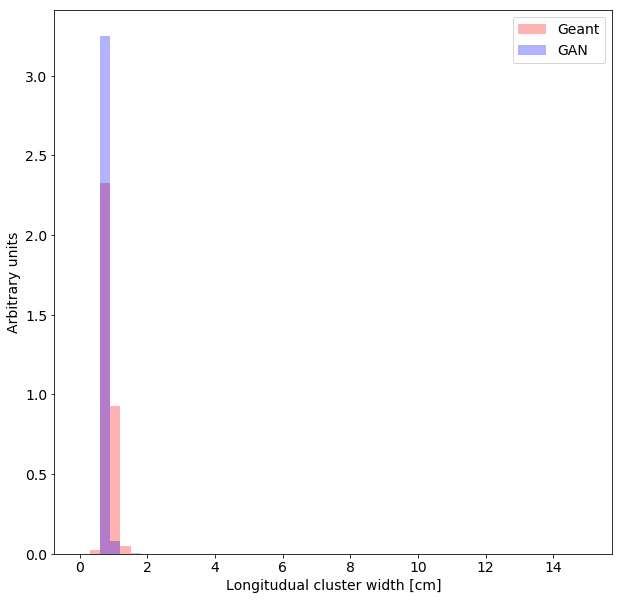

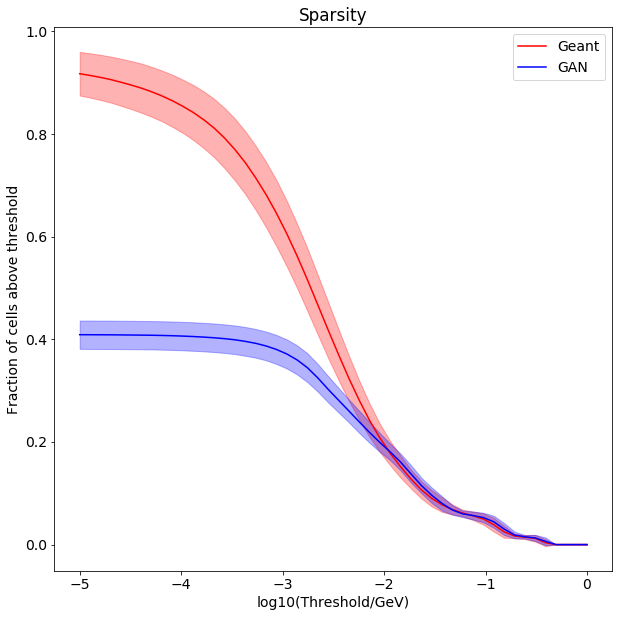

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


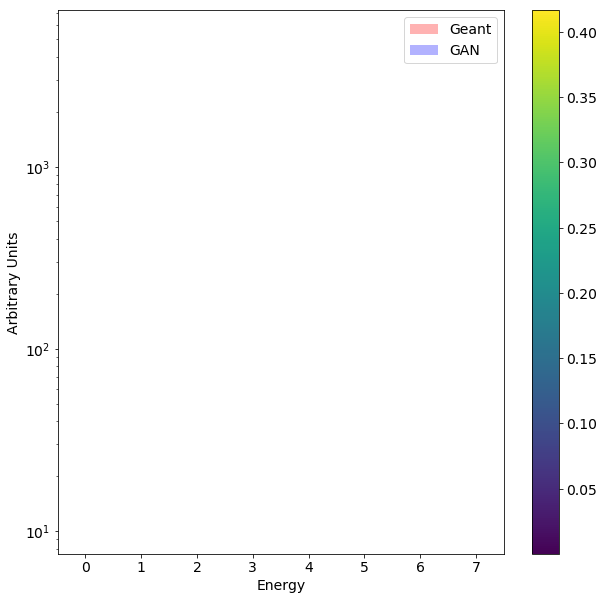

In [36]:
import os
gpWeight = 0.5 # gradient penalty weight; somehow 0.1 is nice, 1 is so so, 10 is bad, 0.01 is vanishing


for testCase in testPlan :
  print()
  batch_size = int(testCase[0])  # Batch size during training
  num_epochs = testCase[1]  # 5 for example, need much more for learning
  ganFile = resultingName 
  print(ganFile + ' is found?     ' + str(os.path.isfile(ganFile)))
  pdfFile = resultingName + '_' + str(batch_size)
  itersPerEpoch = len(dataSet) / batch_size
  print(pdfFile + '\t' + str(itersPerEpoch))
  debugg = trainer.Debugg(itersPerEpoch / 1, itersPerEpoch, min(num_epochs, 25)) #plot set to big number to force trainer to plot generated images only once per epoch
  

  problem = domain.parameters.ProblemSize(nz, ngf, nc, batch_size, imgSize)
                                        
  dataLoader = torch.utils.data.DataLoader(dataSet, batch_size=batch_size, shuffle=True, num_workers=1)

  lossCalculator = training.losses.GanLoss(device, problem, nn.BCELoss()) if type == mygan.GANS.GAN \
        else (training.losses.WganLoss if type == mygan.GANS.WGAN else training.losses.CramerEneryGanLoss)(problem,
                                                                                                           training.losses.GradientPenalizer(gpWeight,True,ngpu > 0))
  #training phase
  netG.train(), netD.train()
  ganTrainer = trainer.Trainer(device, problem, lossCalculator, initOptimizer, lambda d: d[0], ganFile, debugg)

  ui = plotUi.PDFPlotUi(pdfFile)
  painter = painters.ECalPainter(ui)
  print("Starting Training Loop...")
  start = timer()
  dopt, gopt = ganTrainer.train(netD, netG, dataLoader, num_epochs, hyperParams, painter, 8)
    # painter.plotFake(netG.forward(torch.randn(128000, nz, 1, 1, device=device)), num_epochs, 0)
  end = timer()
  print('!!!!!!!!!!!!!!!!!! TIME ELAPSED : ' + str(end - start))
  
  ui.toView(lambda: painters.plotLosses(ganTrainer.G_losses, ganTrainer.D_losses))
  latest = min(num_epochs, 5000)
  ui.toView(lambda: painters.plotLosses(ganTrainer.G_losses[-latest:], ganTrainer.D_losses[-latest:]))
  if type != mygan.GANS.GAN:
      ui.toView(lambda: painters.plotGradPenalties(ganTrainer.ganLoss.gradientPenalizer.penalties, ganTrainer.ganLoss.gradientPenalizer.norms))

  ui.close()
  
                                                                                                                                                                                                                     
  #evaluation phase
  netG.eval(), netD.eval()
    
  shape = ecalDataPojo.response.shape
  print(shape)

  with torch.no_grad():
    tonnsOfNoise = torch.randn(shape[0], nz, 1, 1, device=device)
    generated = netG(tonnsOfNoise)
    fakeData = domain.ecaldata.EcalData(generated.reshape(shape).cpu().numpy(), ecalDataPojo.momentum, ecalDataPojo.point)

  OAF.runAnalytics('/' + pdfFile, ecalDataPojo, fakeData)

  plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))  
  plt.colorbar()
  plt.show()
  
  #finally we want to save our results to mounted GoogleDrive
  #%cp -v $ganFile*  '/ecal/My Drive/ecal/testIncreaseBatchSizeX10'
                                                                                                            
                                                                                                              
  
  



EnergyDeposit  shape: (50000, 30, 30)
 min: 0.0	 max: 120.51937607980491
 first particle Momentum :  [0.15657315 0.14722511 2.4455745 ]
 Point :[ -1.00722767  -0.96538278 -19.8       ]
 particle type is : 22


/content/diving-deep-learning/analytics/plotAnalytics.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img) if logScale else img, interpolation='nearest')


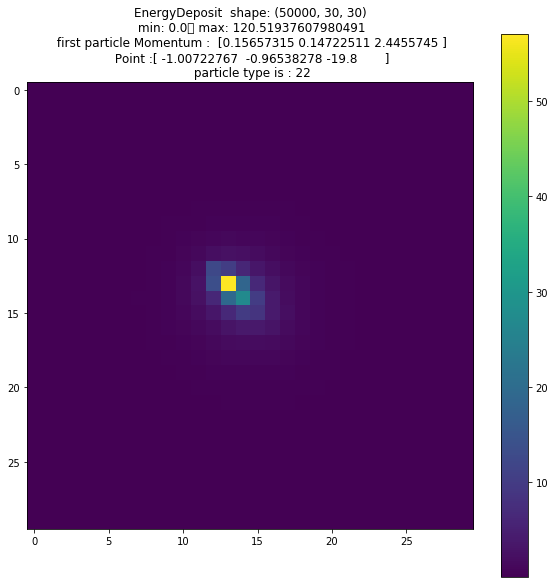

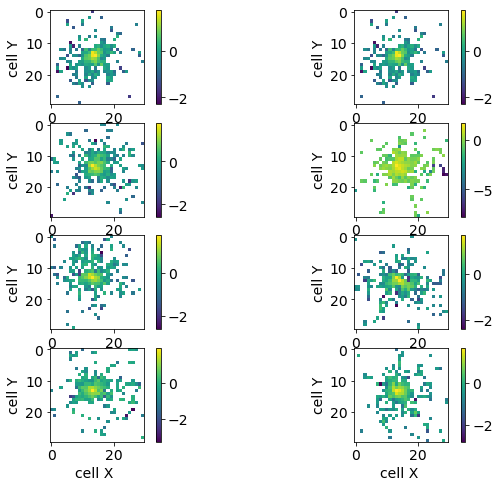

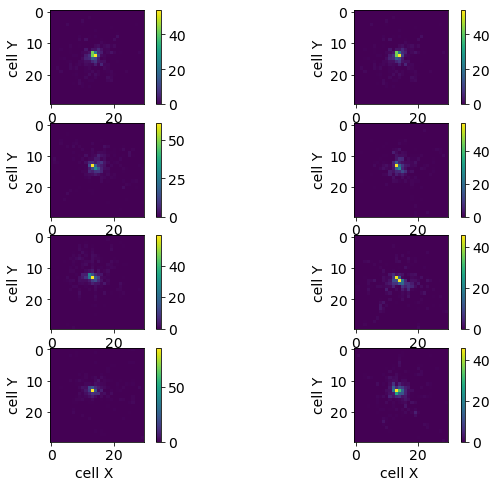

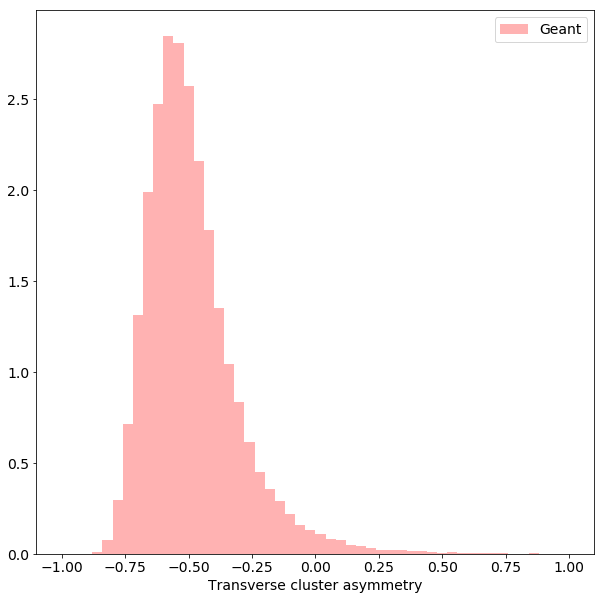

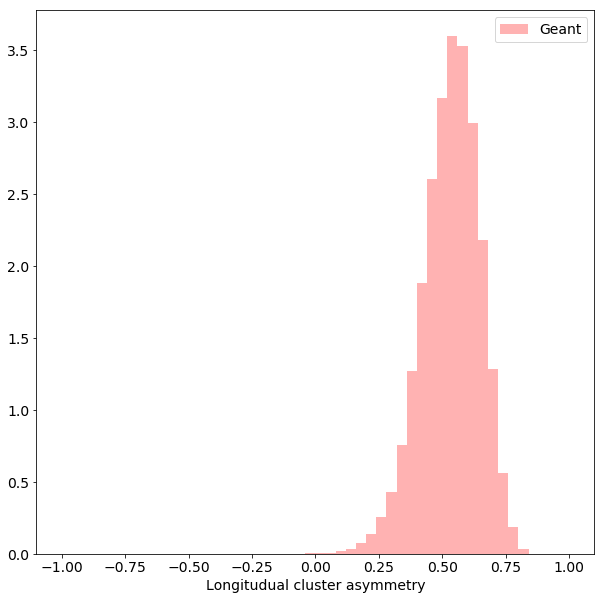

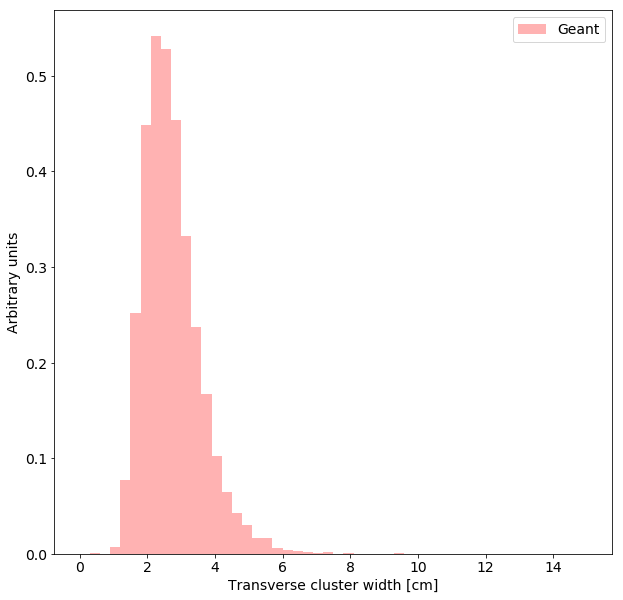

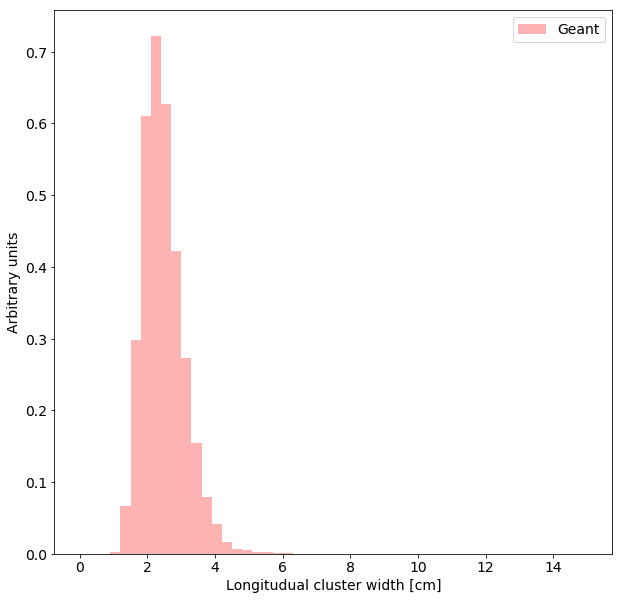

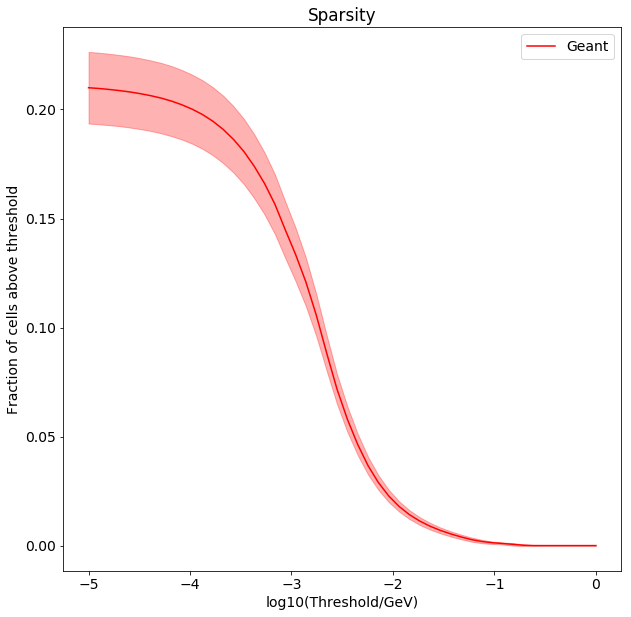

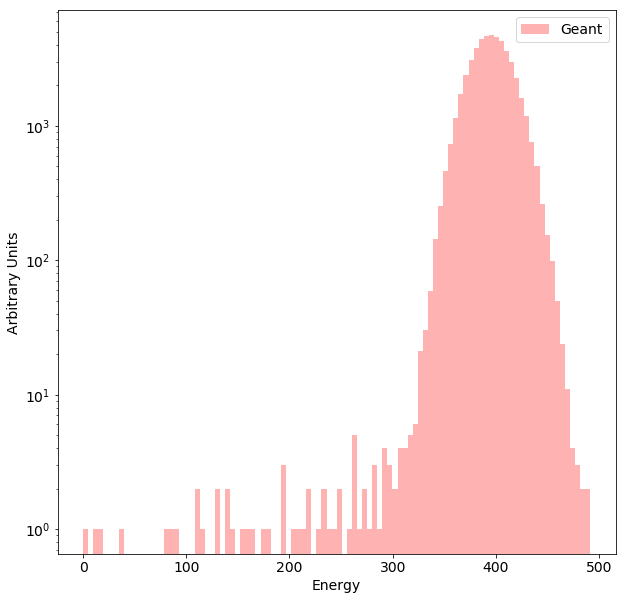

In [11]:
from analytics import optimized_analytic_funcs as OAF

ecalAnalized = OAF.runAnalytics(datasetName, ecalDataPojo, None)
#OAF.runAnalytics(datasetName, ecalDataPojo, None, ecalAnalized)
torch.save(ecalAnalized, resultingName + '_analytic' + iogan.EXTENSION)

EnergyDeposit  shape: (50000, 30, 30)
 min: 0.0	 max: 120.51937607980491
 first particle Momentum :  [0.15657315 0.14722511 2.4455745 ]
 Point :[ -1.00722767  -0.96538278 -19.8       ]
 particle type is : 22
 Resized to 8x8


/content/diving-deep-learning/analytics/plotAnalytics.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img) if logScale else img, interpolation='nearest')


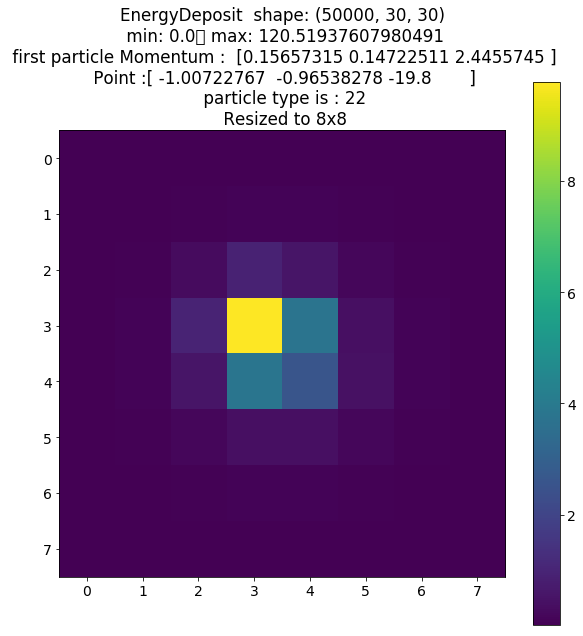

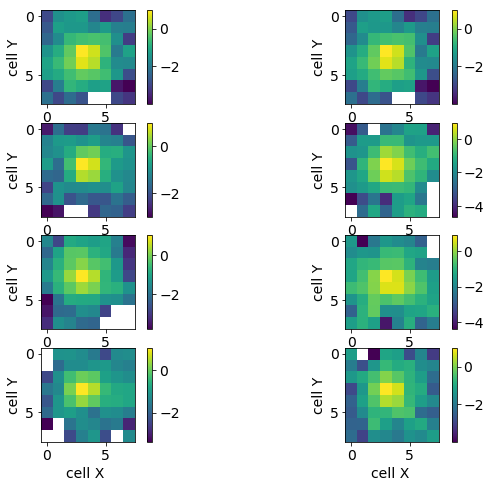

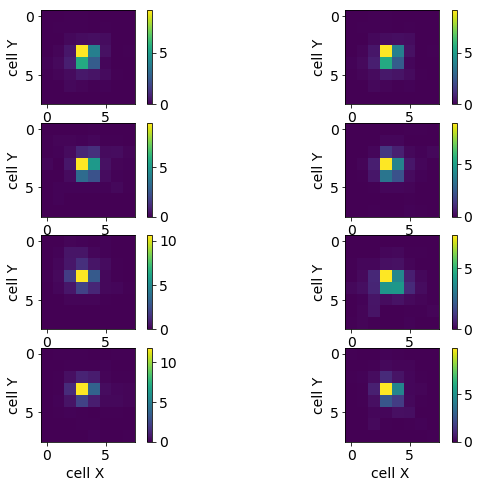

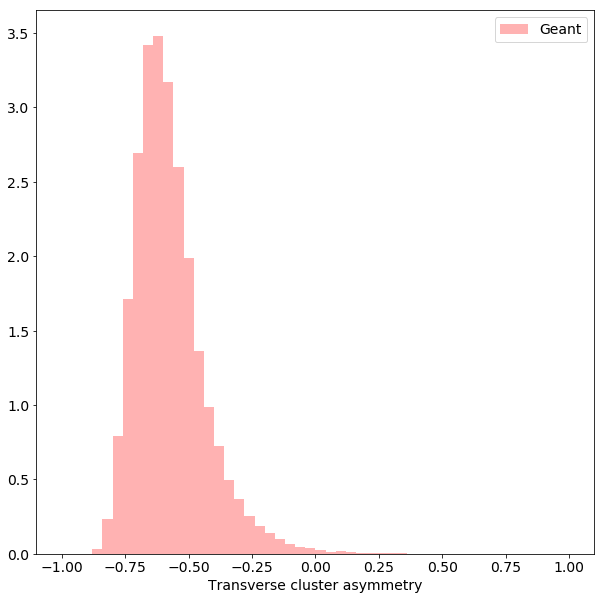

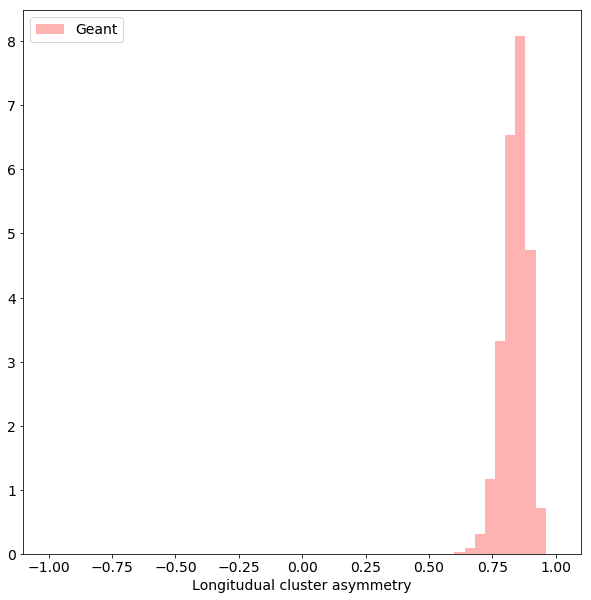

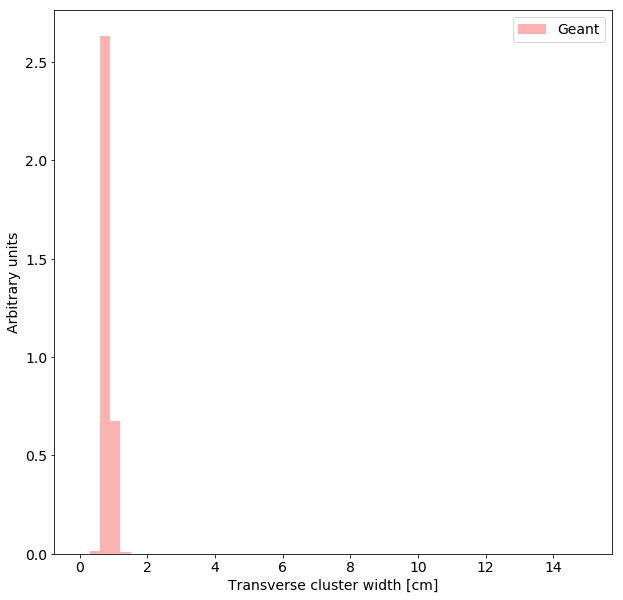

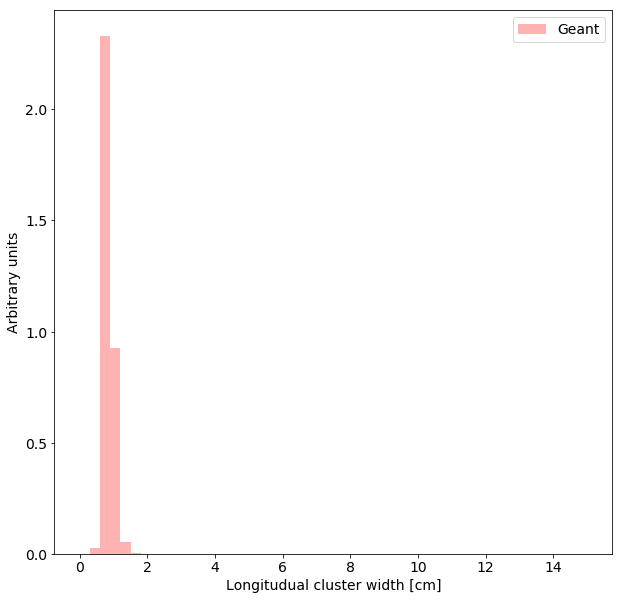

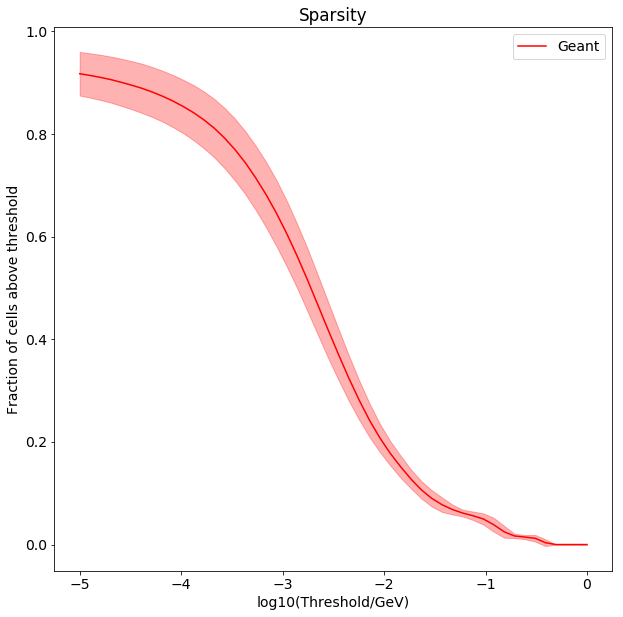

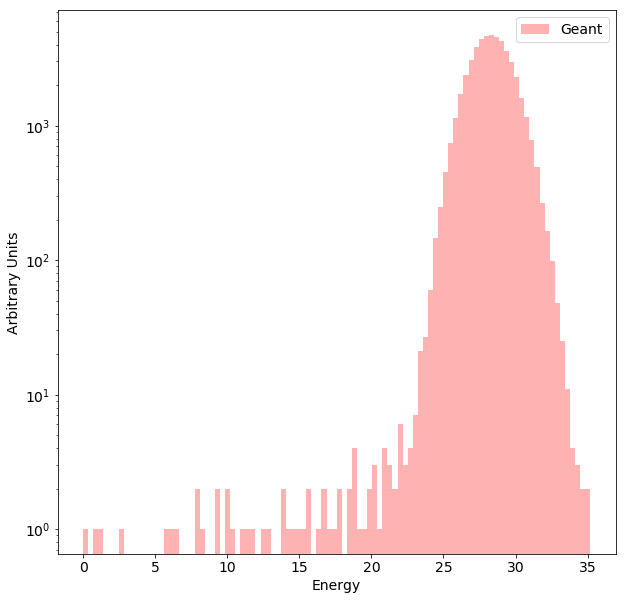

In [15]:
resized = OAF.runAnalytics(datasetName, domain.ecaldata.resizeResponses(ecalDataPojo, 8), None)
#OAF.runAnalytics(datasetName, ecalDataPojo, None, ecalAnalized)
#torch.save(ecalAnalized, resultingName + '_analytic' + iogan.EXTENSION)

In [0]:
def plotLosses(G_losses, D_losses):
    plt.figure()
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

def plotGradPenalties(penalties, norms):
    plt.figure()
    plt.title("Gradient Penalties and Norms During Training")
    plt.plot(penalties, label="P")
    plt.plot(norms, label="N")
    plt.xlabel("iterations")
    plt.ylabel("Value")
    plt.legend()

In [0]:
checkpoint = torch.load(ganFile)

netD.load_state_dict(checkpoint['D_state'])
netG.load_state_dict(checkpoint['G_state'])
netG.eval(), netD.eval()

%cd /
%cd content/
ecalData = AF.parseEcalData(datasetName)

%cd /
%cd content/diving-deep-learning/
    
    
shape = ecalData.response.shape
print(shape)

with torch.no_grad():
  tonnsOfNoise = torch.randn(shape[0], nz, 1, 1, device=device)
  generated = netG(tonnsOfNoise)
fakeData = AF.EcalData(generated.reshape(shape).cpu().numpy(), ecalData.momentum, ecalData.point)



In [0]:
ganFile = resultingName
checkpoint = torch.load(ganFile + '.pth.pth')
checkpoint.keys()

dict_keys(['fixedNoise', 'D_state', 'G_state', 'Dopt', 'Gopt', 'epoch', 'DLoss', 'GLoss'])

In [0]:
  #evaluation phase
  netG.eval(), netD.eval()
    
  shape = ecalDataPojo.response.shape
  print(shape)

  with torch.no_grad():
    tonnsOfNoise = torch.randn(shape[0], nz, 1, 1, device=device)
    generated = netG(tonnsOfNoise)
    fakeData = domain.ecaldata.EcalData(generated.reshape(shape).cpu().numpy(), ecalDataPojo.momentum, ecalDataPojo.point)

  OAF.runAnalytics('/' + ganFile, ecalDataPojo, fakeData)

  plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))  
  plt.colorbar()
  plt.show()       

In [0]:
#%cp -v $ganFile*   '/ecal/My Drive/ecal/testDiffBatchSize'
%mkdir   '/ecal/My Drive/ecal/testIncreaseBatchSizeX10'
#%cp -v resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_incBS_10000*  '/ecal/My Drive/ecal/testIncreaseBatchSizeNoBN_LONG'

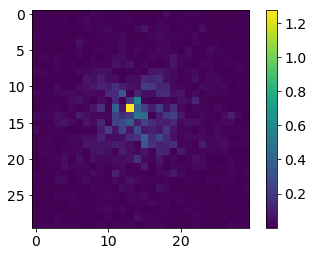

In [0]:
if (ecalDataPojo.response.shape[0] == fakeData.response.shape[0]) :
  plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))
  plt.colorbar()
  plt.show()

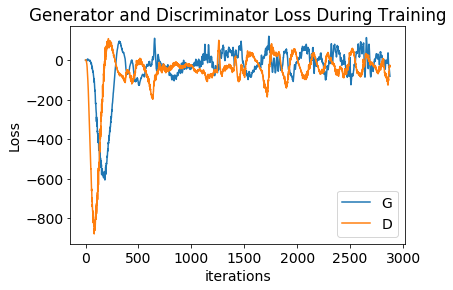

In [0]:
lalalala = 5000
painters.plotLosses(ganTrainer.G_losses[-lalalala:], ganTrainer.D_losses[-lalalala:])

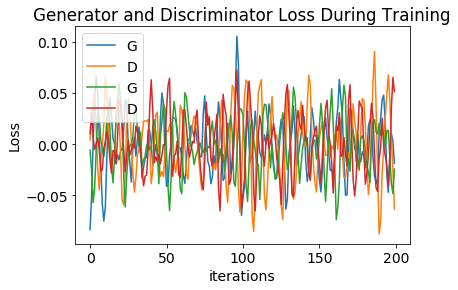

In [0]:
lalalala = 200
painters.plotLosses(ganTrainer.G_losses[-lalalala:], ganTrainer.G_losses[-2*lalalala:-lalalala])
painters.plotLosses(ganTrainer.G_losses[-3*lalalala:-2*lalalala], ganTrainer.G_losses[-4*lalalala:-3*lalalala])


In [0]:
print(netG)
print(netD)

GenEcal(
  (main): Sequential(
    (0): ConvTranspose2d(100, 120, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(120, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(60, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(30, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU()
  )
)
DiscEcal(
  (main): Sequential(
    (0): Conv2d(1, 30, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(30, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyRe

In [33]:
print(netG)
print(netD)

GenEcal(
  (main): Sequential(
    (0): ConvTranspose2d(100, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): ConvTranspose2d(60, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): ConvTranspose2d(30, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU()
  )
)
DiscEcal(
  (main): Sequential(
    (0): Conv2d(1, 30, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(30, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(60, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [0]:
import torch.nn as nn
import torch.nn.functional as F
import mygan

# DCGAN, use optAdam or optRMSProp optimizers
#
class DiscEcal(nn.Module):
    def __init__(self, type, hyper, problem):
        super(DiscEcal, self).__init__()
        self.ngpu = hyper.ngpu
        self.type = type
        nfx2 = problem.nf * 2
        nfx4 = problem.nf * 4
        kernel_size = 4
        stride = 2
        self.main = nn.Sequential(
             nn.Conv2d(problem.nc, problem.nf, 2, stride, 1, bias=False), nn.LeakyReLU(0.2),
             nn.Conv2d(problem.nf, nfx2, kernel_size, stride, 1, bias=False),
             nn.LeakyReLU(0.2),
             nn.Conv2d(nfx2, 1, kernel_size, stride, 1, bias=False)
        )

    def forward(self, x):
        output = self.main(x)
        if self.type == mygan.GANS.GAN :
            output = F.sigmoid(output)
        return output

class GenEcal(nn.Module):
    def __init__(self, type, hyper, problem):
        super(GenEcal, self).__init__()
        self.ngpu = hyper.ngpu
        kernel_size = 4
        stride = 2
        self.nfx4 = problem.nf * 4
        self.nfx2 = problem.nf * 2
        self.main = nn.Sequential(
            #output 120x4x4
            nn.ConvTranspose2d(problem.nz, self.nfx2, kernel_size, stride, 1, bias=False), #nn.BatchNorm2d(self.nfx2),
            nn.ReLU(),
            #output 30x16x16
            nn.ConvTranspose2d(self.nfx2, problem.nf, kernel_size, stride, 1, bias=False), #nn.BatchNorm2d(problem.nf),
            nn.ReLU(),
            nn.ConvTranspose2d(problem.nf, problem.nc, 2, stride, 0, bias=False),
            nn.ReLU() # ReLU here, because we need 0+ values
        )


    def forward(self, x):
        return self.main(x)